# House Price Regression
Predict the house prices using feature creation and regression.

Dataset comes from Kaggle:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.learning_curve import learning_curve
from matplotlib.ticker import FuncFormatter
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

C:\Users\aaron\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\aaron\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\aaron\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
train_data = pd.read_csv('data/train.csv')

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Let's make a deep copy of our data to wrangle and munge.

# Categorical Features
We need to wrangle the data into the right format to perform optimally with our machine learning algos.

For example, some of the values in this data set are strings and our machine learning algos don't handle strings very well. Let's convert these values into integers using mapping techniques like manual maps and dummy variables.

There are two types of categorical features: ordinal and nominal. We'll go through each type and show how we handle them.

## Ordinal features
Ordinal features are categorical variables that have a clear order. These include quality ratings like poor < good < excellent. We can break down the ordinal features into two sets:

1. Universal ordinal features - mapping of integers that can be applied across multiple features.
2. Custom ordinal features - special mapping of integers because the scale is dependent on the feature.

### *Universal ordinal features*
Features that share the same string values and scales across features.

In [4]:
train_data_ordinal = train_data.copy()

In [5]:
universal_ordinal_features = [
    'LandSlope','ExterQual','ExterCond','HeatingQC','KitchenQual',
    'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageQual', 'GarageCond', 'Functional', 'GarageFinish'
]
universal_ordinal_features_map = {
    'nan': 0,
    # LandSlope
    'Sev': 1,
    'Mod': 2,
    'Gtl': 3,
    # ExterQual, ExterCond, HeatingQC, KitchenQual, BsmtQual
    # BsmtCond, FireplaceQu, GarageQual, GarageCond, 
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
    # BsmtFinType1, BsmtFinType2
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6,
    # Functional
    'Sal': 1,
    'Sev': 2,
    'Maj2': 3,
    'Maj1': 4,
    'Min2': 5,
    'Min1': 6,
    'Typ': 7,
    # GarageFinish
    'Unf': 1,
    'RFn': 2,
    'Fin': 3,
}

Let's loop through each column and map the strings to values found in universal ordinal features map.

In [6]:
for column in universal_ordinal_features:
    train_data_ordinal[column] = train_data_ordinal[column].fillna('nan').map(universal_ordinal_features_map)

Make sure we've correctly mapped all the values (don't have any NaN values) in our newly mapped columns.

In [7]:
for column in universal_ordinal_features:
    print(column, set(train_data_ordinal[column]))

LandSlope {2, 3}
ExterQual {2, 3, 4, 5}
ExterCond {1, 2, 3, 4, 5}
HeatingQC {1, 2, 3, 4, 5}
KitchenQual {2, 3, 4, 5}
BsmtQual {0, 2, 3, 4, 5}
BsmtCond {0, 1, 2, 3, 4}
BsmtFinType1 {0, 1, 2, 3, 4, 5, 6}
BsmtFinType2 {0, 1, 2, 3, 4, 5, 6}
FireplaceQu {0, 1, 2, 3, 4, 5}
GarageQual {0, 1, 2, 3, 4, 5}
GarageCond {0, 1, 2, 3, 4, 5}
Functional {2, 3, 4, 5, 6, 7}
GarageFinish {0, 1, 2, 3}


In [8]:
train_data_ordinal.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,No,6,706,1,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,7,0,0,Attchd,2003.0,2,2,548,3,3,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,3,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,Gd,5,978,1,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,7,1,3,Attchd,1976.0,2,2,460,3,3,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,3,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,Mn,6,486,1,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,7,1,3,Attchd,2001.0,2,2,608,3,3,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,3,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,No,5,216,1,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,7,1,4,Detchd,1998.0,1,3,642,3,3,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,3,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,Av,6,655,1,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,7,1,3,Attchd,2000.0,2,3,836,3,3,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Looks good! Let's move on to mapping the custom ordinal features to be integer value.

### *Custom ordinal features*
Features that don't seem to follow the pattern of universal ordinal features.

In [9]:
custom_ordinal_features_map = {
    # No 'Poor' rating for pools
    'PoolQC': {
        'nan': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4,
    }
}

In [10]:
for column_name, mapping in custom_ordinal_features_map.items():
    train_data_ordinal[column_name] = train_data_ordinal[column_name].fillna('nan').map(mapping)

Let's check our column and see if we've mapped the strings to integers. And filled in NaN values as 0!

In [11]:
set(train_data_ordinal['PoolQC'])

{0, 1, 3, 4}

In [12]:
set(train_data['PoolQC'])

{'Ex', 'Fa', 'Gd', nan}

And we shouldn't forget to add PoolQC to our nominal features list

In [13]:
ordinal_features = universal_ordinal_features.copy()
ordinal_features.append('PoolQC')

## Nominal features
Nominal features are categorical variables that do not have a clear order. We will create dummy variables to transform the string values into 0 or 1 values. 

For example, the feature 'Street' has two possible values: Pave and Grvl. We will transform the single 'Street' column into two columns:

- Street_Grvl
- Street_Pave

If the house has a paved street, they will get a value of 1 for Street_Pave and a value of 0 for Street_Grvl.

Let's make another copy of our training data set to build out the dummy variables.

In [14]:
train_data_nominal = train_data.copy()

In order for dummy variables to be created automagically by the pandas function `get_dummies()`, we need the values to be of type string. All of our nominal features have data of type string except one, MSSubClass.

In [15]:
train_data_nominal['MSSubClass'] = train_data_nominal['MSSubClass'].apply(str)

Let's create the dummy variables!

In [16]:
nominal_features = [
    'MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities',
    'LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
    'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
    'BsmtExposure','Heating','CentralAir','Electrical','GarageType','PavedDrive',
    'Fence','MiscFeature','SaleType','SaleCondition'
]

train_data_nominal = pd.get_dummies(train_data_nominal[nominal_features])
train_data_nominal.columns.values[0:10]

array(['MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180',
       'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30',
       'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60'],
      dtype=object)

## Completed categorical features
Let's build a single dataframe that holds both our new ordinal and nominal features.

In [17]:
train_data_categorical = train_data_ordinal[ordinal_features].join(train_data_nominal)

In [18]:
train_data_categorical.head()

,LandSlope,ExterQual,ExterCond,HeatingQC,KitchenQual,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageQual,GarageCond,Functional,GarageFinish,PoolQC,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3,4,3,5,4,4,3,6,1,0,3,3,7,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3,3,3,5,3,4,3,5,1,3,3,3,7,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

# Continuous Features

Let's wrangle the non-categorical features of our dataset, the continuous variables. These are much easier and only require us normalization or standardization.

In [19]:
train_data_continuous = train_data.copy()

In [20]:
y = train_data_continuous['SalePrice']
y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [21]:
categorical_features = universal_ordinal_features + nominal_features + list(custom_ordinal_features_map.keys())

In [22]:
train_data_continuous = train_data_continuous.drop(categorical_features, axis=1)
train_data_continuous = train_data_continuous.drop(['Id','SalePrice'], axis=1)
train_data_continuous.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


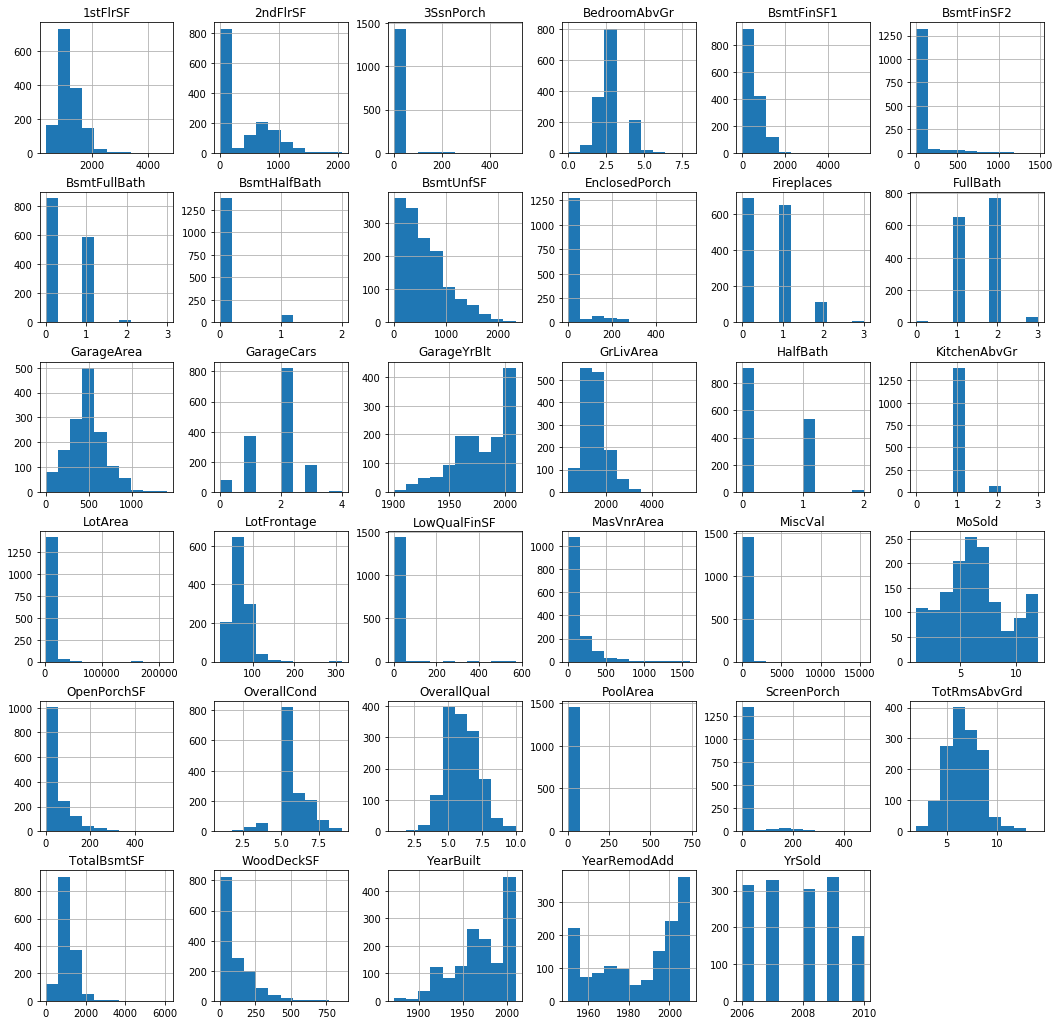

In [23]:
plots = train_data_continuous.hist(figsize=(18,18))
for plot in plots:
    plot

## Features to Normalize

Normalizing features rescales the values to fit in a range of [0,1]. This is valuable because it brings our different features onto the same scale, can help our regression run faster, andnecessary if we add regularization paramters (L1 and L2).

In [24]:
train_data_continuous_columns = train_data_continuous.columns.values

mms = MinMaxScaler()
train_data_continuous_norm = mms.fit_transform(train_data_continuous.fillna(0))
train_data_continuous_norm = pd.DataFrame(train_data_continuous_norm, columns=train_data_continuous_columns)
train_data_continuous_norm.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.207668,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,0.064212,0.140098,0.119780,0.413559,0.0,0.259231,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.500000,0.000000,0.996517,0.50,0.386460,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50
1,0.255591,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,0.121575,0.206547,0.212942,0.000000,0.0,0.174830,0.000000,0.5,0.666667,0.0,0.375,0.333333,0.333333,0.333333,0.983085,0.50,0.324401,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25
2,0.217252,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,0.185788,0.150573,0.134465,0.419370,0.0,0.273549,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.333333,0.333333,0.995522,0.50,0.428773,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50
3,0.191693,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,0.231164,0.123732,0.143873,0.366102,0.0,0.260550,0.333333,0.0,0.333333,0.0,0.375,0.333333,0.416667,0.333333,0.994030,0.75,0.452750,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00
4,0.268371,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,0.209760,0.187398,0.186095,0.509927,0.0,0.351168,0.333333,0.0,0.666667,0.5,0.500,0.333333,0.583333,0.333333,0.995025,0.75,0.589563,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50


## Features to Standardize

Standardizing features centers the feature columns at mean 0 and standard deviation 1 (think normal distribution). Good for when we want to preserve outliers in our dataset.

(intentionally left blank)

## Finalized features
Let's bring our dataframes together!

In [25]:
X = train_data_categorical.join(train_data_continuous_norm)
X.head()

,LandSlope,ExterQual,ExterCond,HeatingQC,KitchenQual,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageQual,GarageCond,Functional,GarageFinish,PoolQC,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,3,4,3,5,4,4,3,6,1,0,3,3,7,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0

# Linear Regression

## Ridge Regression
Finally! Let's train a linear regression model using L2 regularization (penalizes large weight coeffcicients and overfitting), also known as Ridge Regression.

In [26]:
ridge = Ridge(alpha=1.0)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [28]:
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [29]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [30]:
def currency(x, pos):
    'The two args are the value and tick position'
    if x >= 1000000:
        return '${:1.1f}M'.format(x*1e-6)
    return '${:1.0f}K'.format(x*1e-3)
currency_format = FuncFormatter(currency)

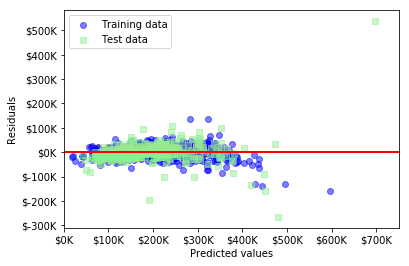

In [31]:
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(currency_format)
ax.xaxis.set_major_formatter(currency_format)
plt.scatter(y_train_pred, y_train_pred- y_train, c='blue', marker='o', label='Training data', alpha=0.5)
plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data', alpha=0.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-100000, xmax= 10000000, lw= 2, color='red')
plt.xlim([0, 750000])
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [32]:
feat_labels = X_train.columns
regression_coeffs = ridge.coef_
regression_coeffs_indices = np.argsort(regression_coeffs)[::-1]
for f in range(X_train.shape[1]):
    print( "%s %f" % ( feat_labels[f], regression_coeffs[regression_coeffs_indices[f]]))

LandSlope 85551.880407
ExterQual 75143.327916
ExterCond 66544.234144
HeatingQC 60995.712114
KitchenQual 59300.354271
BsmtQual 58419.195964
BsmtCond 58086.537922
BsmtFinType1 54646.985348
BsmtFinType2 52980.146028
FireplaceQu 51657.202754
GarageQual 48207.401317
GarageCond 43267.954241
Functional 43155.002481
GarageFinish 37342.371779
PoolQC 35762.868048
MSSubClass_120 31887.847974
MSSubClass_160 30083.728144
MSSubClass_180 29467.931776
MSSubClass_190 21635.640248
MSSubClass_20 21477.364160
MSSubClass_30 21373.262520
MSSubClass_40 21057.292178
MSSubClass_45 19523.525717
MSSubClass_50 19055.632908
MSSubClass_60 16599.340949
MSSubClass_70 15972.571822
MSSubClass_75 15760.848119
MSSubClass_80 15613.399940
MSSubClass_85 14908.579644
MSSubClass_90 14093.883494
MSZoning_C (all) 13787.275973
MSZoning_FV 13499.586127
MSZoning_RH 13414.073621
MSZoning_RL 12850.225379
MSZoning_RM 11934.764350
Street_Grvl 11789.353250
Street_Pave 11776.313265
Alley_Grvl 11626.469857
Alley_Pave 11413.824134
LotShap

## Random forests

We can also measure feature importance using Random forests and compare them to the weights assigned in our L2 regression model. This will help us figure out which features are most important in predicting sale price, and to prevent overfitting on our training data.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [34]:
forest = RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1, max_features=125, oob_score=True, max_depth=20)

In [35]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=125, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [36]:
feat_labels = X_train.columns
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for ix, f in enumerate(range(X_train.shape[1])):
    print( "%d) %s %f" % (ix, feat_labels[f], importances[indices[f]]))

print(indices)

0) LandSlope 0.038280
1) ExterQual 0.034261
2) ExterCond 0.031324
3) HeatingQC 0.030928
4) KitchenQual 0.029663
5) BsmtQual 0.028383
6) BsmtCond 0.026694
7) BsmtFinType1 0.024566
8) BsmtFinType2 0.023469
9) FireplaceQu 0.021886
10) GarageQual 0.020880
11) GarageCond 0.020608
12) Functional 0.019605
13) GarageFinish 0.019387
14) PoolQC 0.019216
15) MSSubClass_120 0.017206
16) MSSubClass_160 0.016246
17) MSSubClass_180 0.014867
18) MSSubClass_190 0.013830
19) MSSubClass_20 0.012193
20) MSSubClass_30 0.011992
21) MSSubClass_40 0.011974
22) MSSubClass_45 0.010482
23) MSSubClass_50 0.010152
24) MSSubClass_60 0.009883
25) MSSubClass_70 0.009268
26) MSSubClass_75 0.008695
27) MSSubClass_80 0.007798
28) MSSubClass_85 0.007243
29) MSSubClass_90 0.007206
30) MSZoning_C (all) 0.006927
31) MSZoning_FV 0.006811
32) MSZoning_RH 0.006509
33) MSZoning_RL 0.006468
34) MSZoning_RM 0.006452
35) Street_Grvl 0.006200
36) Street_Pave 0.005941
37) Alley_Grvl 0.005920
38) Alley_Pave 0.005798
39) LotShape_IR1 

In [37]:
y_train_forest_pred = forest.predict(X_train)
y_test_forest_pred = forest.predict(X_test)

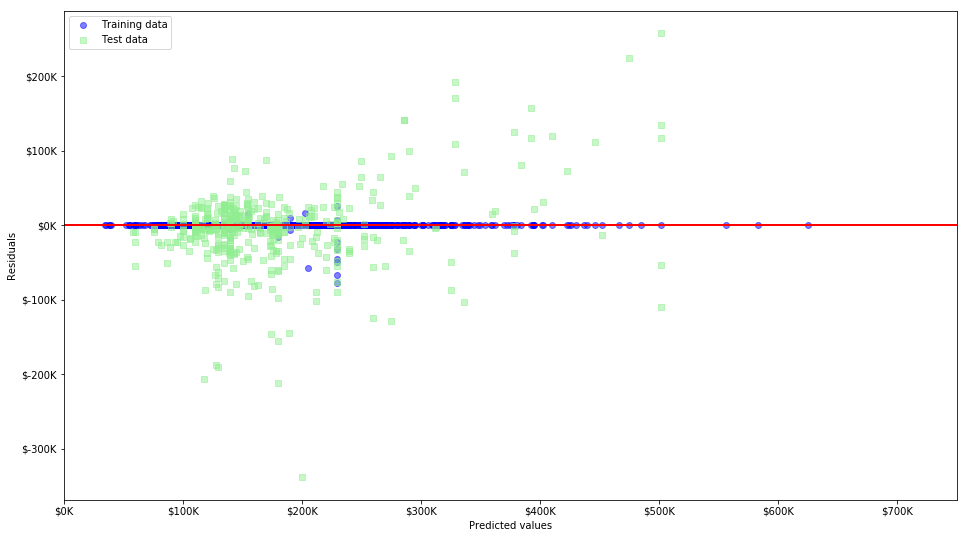

In [38]:
fig2, ax2 = plt.subplots()
ax2.yaxis.set_major_formatter(currency_format)
ax2.xaxis.set_major_formatter(currency_format)
plt.scatter(y_train_forest_pred, y_train_forest_pred - y_train, c='blue', marker='o', label='Training data', alpha=0.5)
plt.scatter(y_test_forest_pred, y_test_forest_pred - y_test, c='lightgreen', marker='s', label='Test data', alpha=0.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-100000, xmax= 10000000, lw= 2, color='red')
plt.xlim([0, 750000])
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

Uh oh! Our model is overfitting pretty badly. Let's view the learning curves and see how close to optimal we are. We can then apply K-cross fold validation and adjust a tuning parameter if we find our model to have high variance and want to improve our generalization.

## K-fold cross validation

In [39]:
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)

C:\Users\aaron\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


In [40]:
scores = []
for k, (train, test) in enumerate(kfold):
    forest.fit(X_train.iloc[train], y_train.iloc[train])
    score = forest.score(X_train.iloc[train], y_train.iloc[train])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))

Fold: 1, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.998
Fold: 2, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.969
Fold: 3, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.973
Fold: 4, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.971
Fold: 5, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.977
Fold: 6, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.983
Fold: 7, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.994
Fold: 8, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.991
Fold: 9, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.977
Fold: 10, Class dist.: [0 0 0 ... 0 0 1], Acc: 0.981


In [41]:
y_train_forest_pred = forest.predict(X_train)
y_test_forest_pred = forest.predict(X_test)

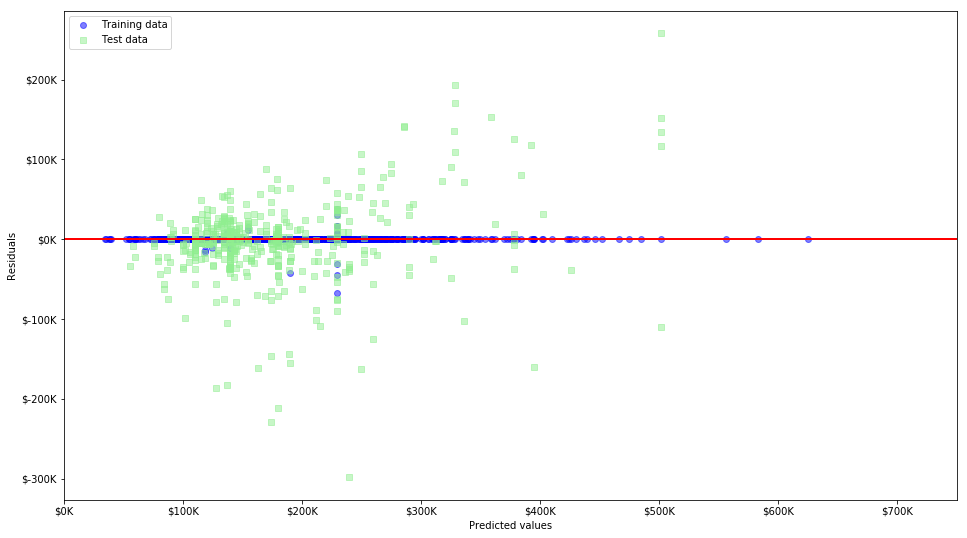

In [42]:
fig3, ax3 = plt.subplots()
ax3.yaxis.set_major_formatter(currency_format)
ax3.xaxis.set_major_formatter(currency_format)
plt.scatter(y_train_forest_pred, y_train_forest_pred - y_train, c='blue', marker='o', label='Training data', alpha=0.5)
plt.scatter(y_test_forest_pred, y_test_forest_pred - y_test, c='lightgreen', marker='s', label='Test data', alpha=0.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-100000, xmax= 10000000, lw= 2, color='red')
plt.xlim([0, 750000])
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

## Learning Curves

In [45]:
train_sizes, train_scores, test_scores, = learning_curve(
    estimator=forest,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1
)

C:\Users\aaron\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


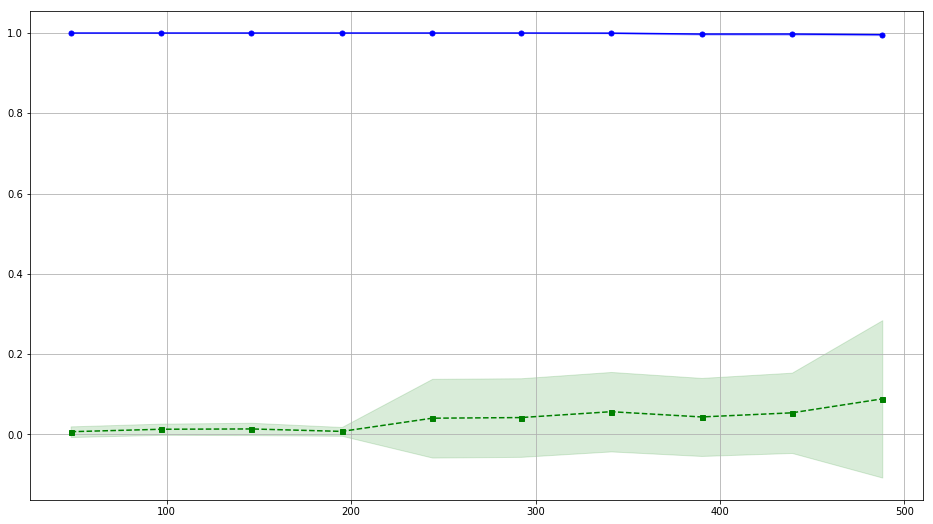

In [46]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue' )
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.15, color='green')
plt.grid()
plt.show()